In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import time
import seaborn as sns
import plot_init as pu
import matplotlib.pyplot as plt
import shap
import pickle
from beeswarm import beeswarm # custom implementation of shap.beeswarm

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

from glob import glob
import os
import joblib
import json

## Loading Data

In [2]:
agg = 'mean'
lookback_window = 60
thresh = 12
run_date = '2022-06-02'# source date

results_root = f'../results/window-{lookback_window}-filter-{thresh}'
file_path = f'predictions/{agg}-window-{lookback_window}-{run_date}-preds.json'
predictions_path = os.path.join(results_root, file_path)
with open(predictions_path, 'r') as f:
    _speed = json.load(f)
    speeds = pd.DataFrame(_speed)

file_path = f'column-labels/{agg}-window-{lookback_window}-{run_date}-columnrefs.pickle'
labels_path = os.path.join(results_root, file_path)
with open(labels_path, 'rb') as f:
    column_labels = pickle.load(f)

featname_map = {
    'dayofweek': 'Day',
    'hour': 'Hour',
    'number_of_lanes': 'Number of Lanes',
    'speed_limit_kph': 'Speed Limit',
    'pix_business_4x4' : 'Nearby Commercial',
    'pix_residential_4x4': 'Nearby Residential', 
    'pix_industrial_4x4' : 'Nearby Industrial',
    'pix_institutional_4x4' : 'Nearby Institutional',
    'elevation' : 'Elevation',
}

data_dir = f'../datasets/inference/window-{lookback_window}-filter-{thresh}'

# load data
test_data = pd.read_csv(f'{data_dir}/{agg}-window-{lookback_window}-test-{run_date}.csv')

# usecols for ML
discrete_num_cols = ['number_of_lanes', 'speed_limit_kph',]
building_types = ['residential', 'business', 'industrial', 'institutional']
pixel_size = '4x4'
landuse_cols = [f'pix_{type_}_{pixel_size}' for type_ in building_types]
num_cols = landuse_cols + discrete_num_cols + ['elevation']

# cat cols
cat_cols = ['hour', 'dayofweek']
features = sorted(cat_cols + num_cols) # sort for reference in feature order

X_test = test_data[features]
X_test.rename(columns=featname_map, inplace = True)


test_data = gpd.GeoDataFrame(test_data, geometry=gpd.points_from_xy(test_data.lon, test_data.lat))
test_data.crs = 'EPSG:4326'
footprints = gpd.read_file("../datasets/Building_Footprints_2015.gpkg")
footprints = footprints[footprints['OBJECTID'].notnull()]
boundaries = gpd.read_file("../datasets/cauayan_shape/Cauayan City Boundary.shp")

def clean_building_class(bclass):
    if bclass in ['residential','residential-ext']:
        return 'residential'
    elif bclass in ['industrial']:
        return 'industrial'
    elif bclass in ['commercial', 'commercial??']:
        return 'business'
    elif bclass in ['institutional', 'insitutional']:
        return 'institutional'
    
footprints['Bldg_Class'] = footprints.Bldg_Class.apply(clean_building_class)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.


In [3]:
def get_score(y_true, y_preds):
    return r2_score(y_true, y_preds)

def rmse(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

def plot_lgb_yyhat(y_true, y_pred, ax, quantity_name='speed (km/hr)'):
    ax.scatter(y_true, y_pred,alpha=0.1, c='green', marker='*', s=2, lw=0)
    ax.set_xlabel(f'true {quantity_name}')
    ax.set_ylabel(f'predicted {quantity_name}')

    ax.set_ylim([i for i in ax.get_xlim()])
    
    # diagonal perfect prediction reference
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, c='0.3',
                   label='perfect prediction', lw=0.4, ls='--')
    ax.legend(loc='upper left', fontsize=pu.tiny, frameon=False)
    ax.set_aspect('equal')
    
    # remove spines
    sns.despine()
    
    r2 = get_score(y_true, y_pred)
    ax.annotate(f"$R^2={r2:.2f}$", size=pu.tiny, xy=(55, 0))
    
    rmse_score = rmse(y_true, y_pred)
    ax.annotate(f"$\mathrm{{RMSE}}={rmse_score:.2f}$", size=pu.tiny, xy=(55, 5))
    return ax

## Prediction scatterplot

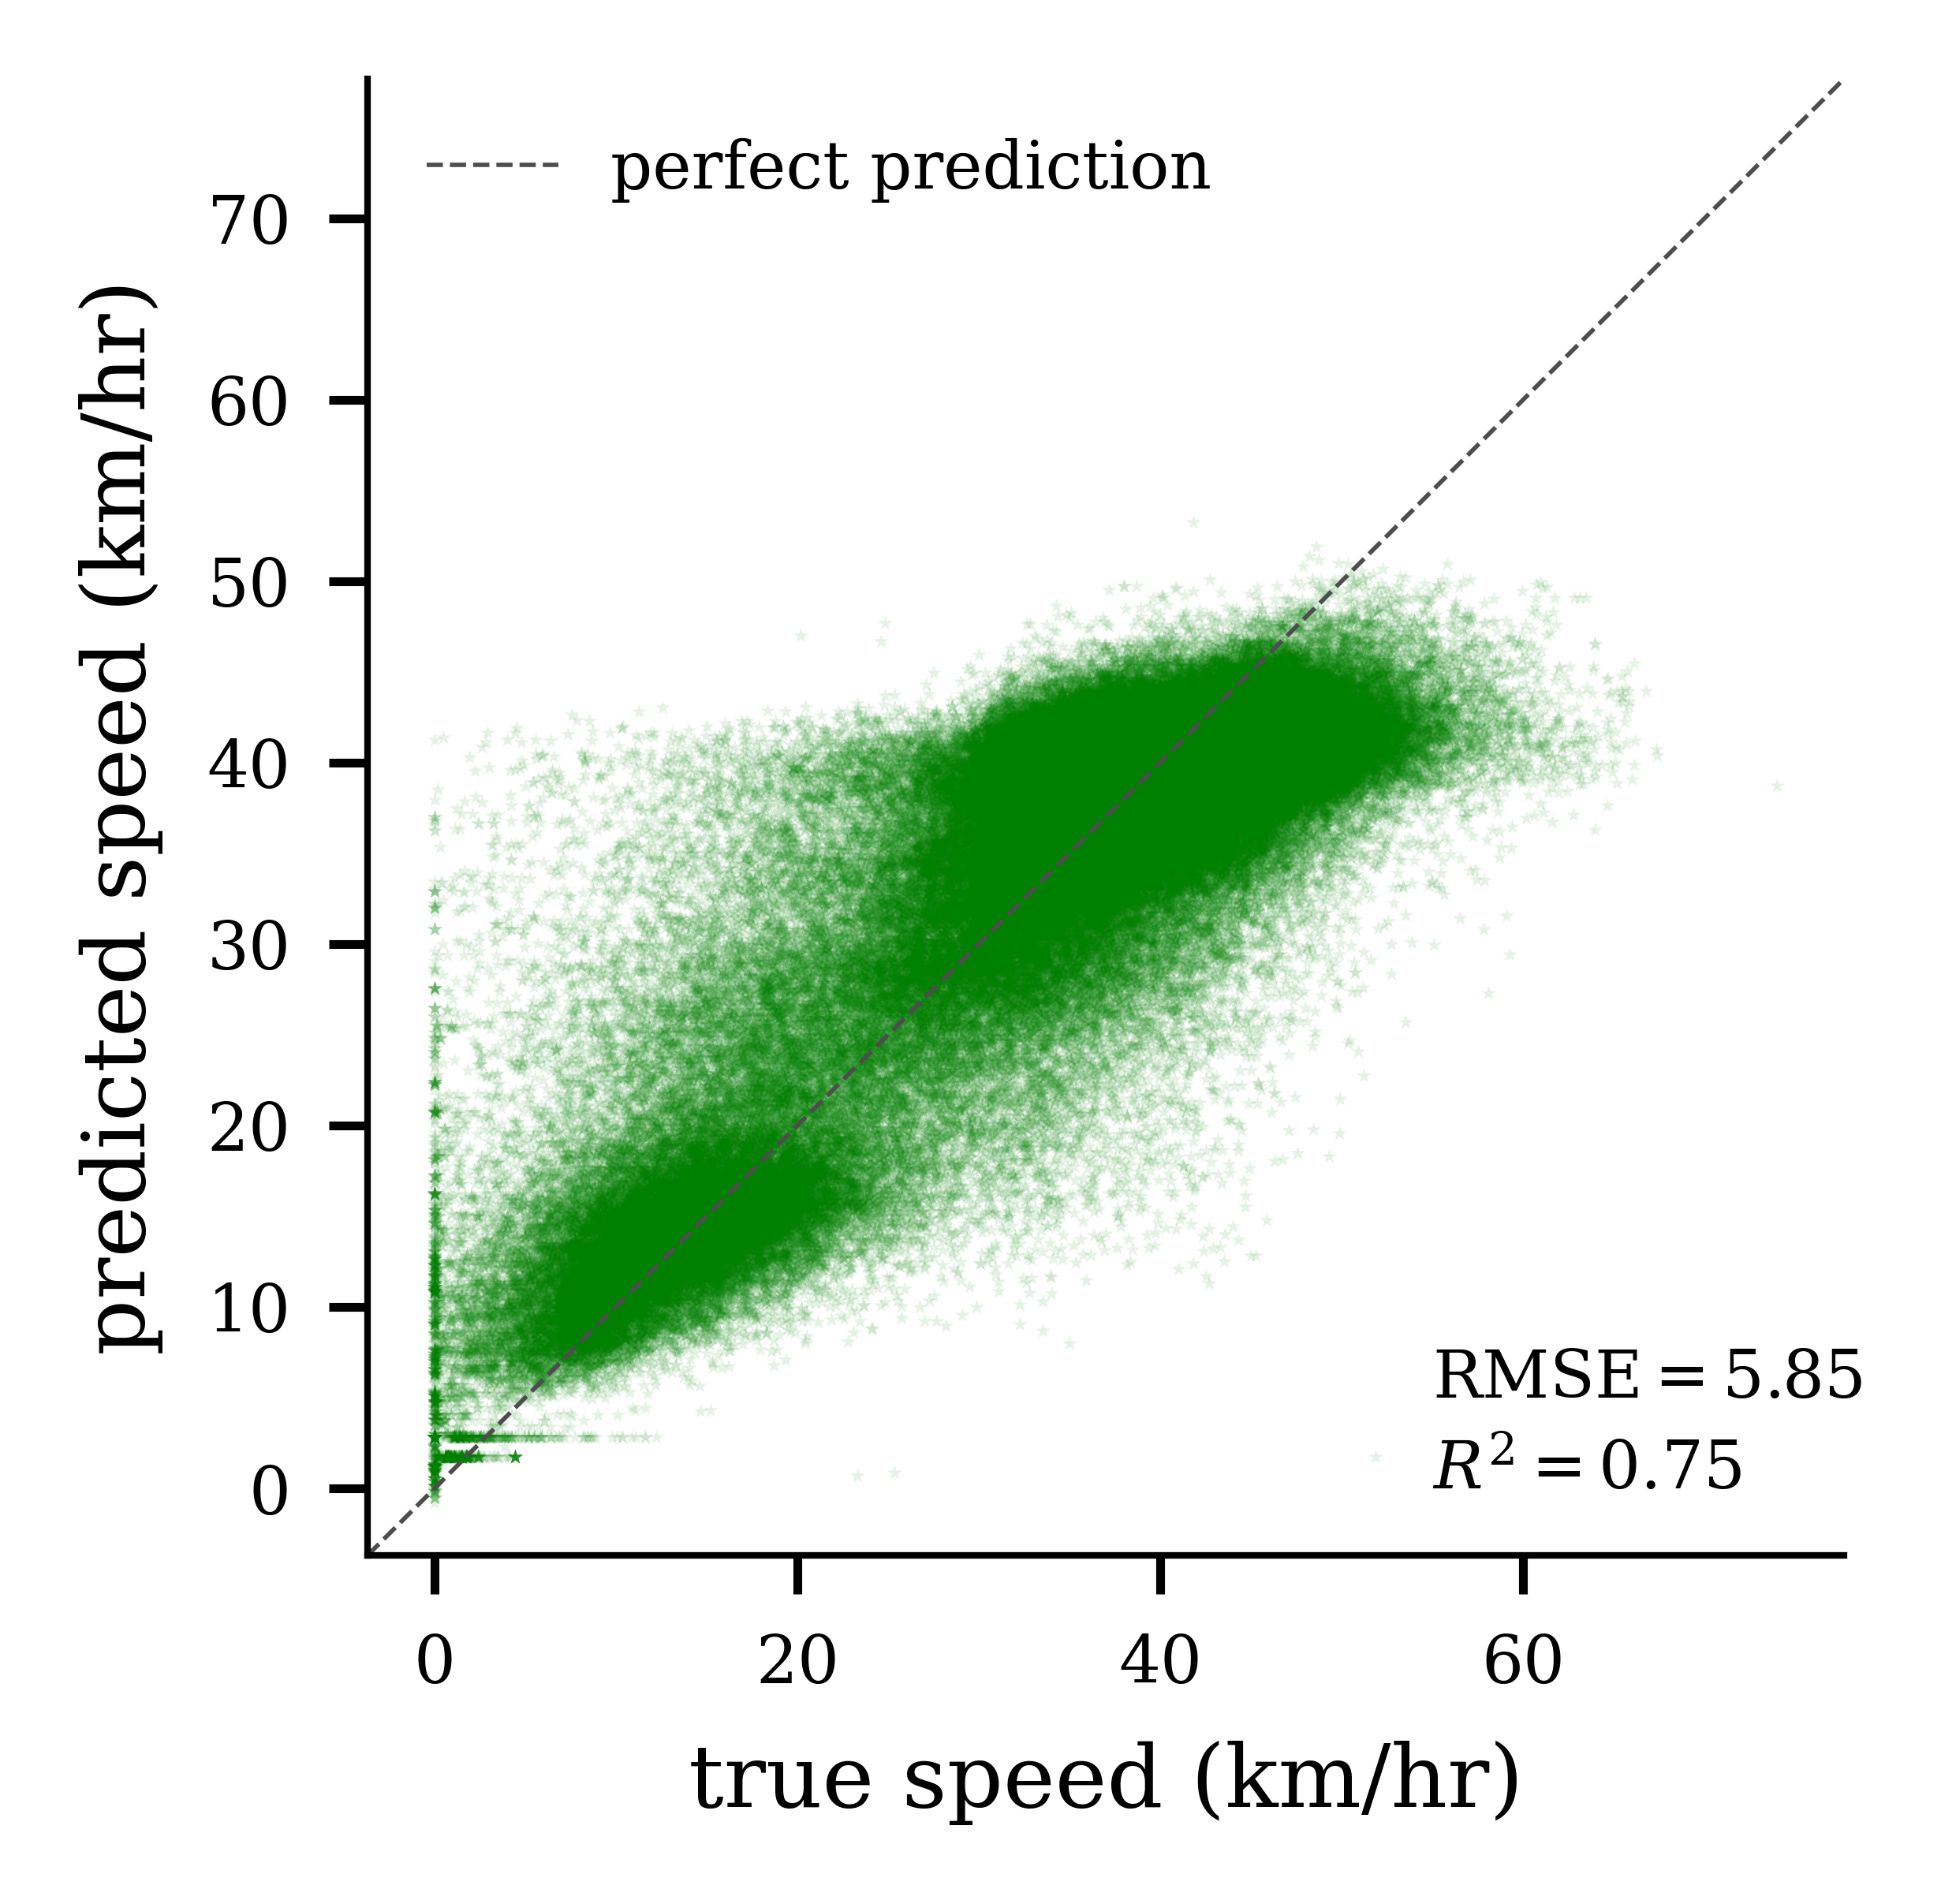

In [4]:
fig, ax = plt.subplots(1)
plot_lgb_yyhat(speeds['true'], speeds['pred'], ax)

save_dir = '../figures/manuscript/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
file_prefix = f'{agg}-window-{lookback_window}-filter-{thresh}-{run_date}'
save_path = os.path.join(save_dir, file_prefix)
fig.savefig(f'{save_path}-yyhat.pdf', bbox_inches='tight')

## Shap plots

In [5]:
source_dir = os.path.join(results_root, 'shap-vals')
filename = f'{agg}-window-{lookback_window}-{run_date}-shap-vals.pickle'

with open(os.path.join(source_dir, filename), 'rb') as f:
    shap_values = pickle.load(f)

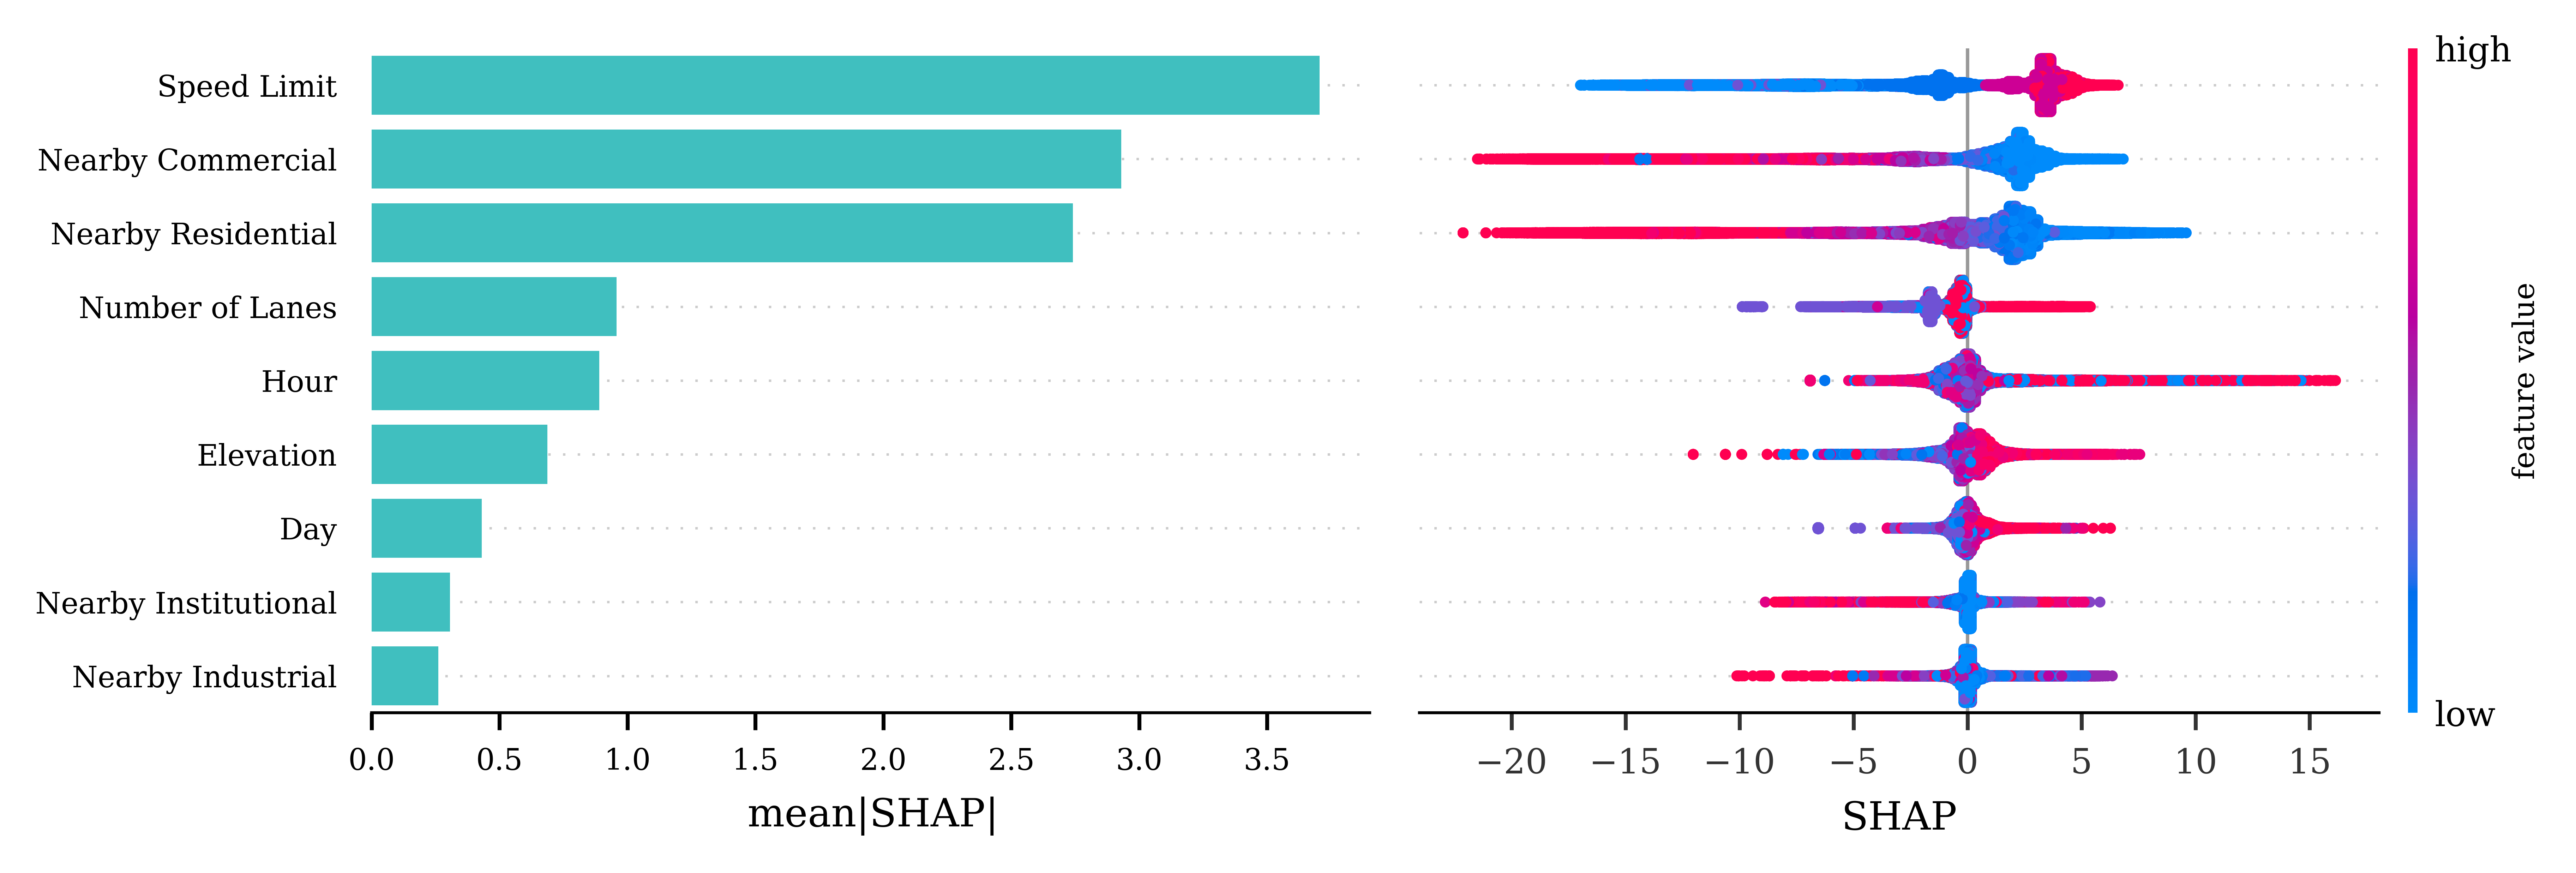

In [6]:
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, axes = plt.subplots(1,2, sharey=True, figsize=pu.figsize_mm(190, aspect=3))
ax = axes[1]

beeswarm(X_test, shap_values, ax, reverse_order=True)
feature_names = X_test.columns
feature_order = np.argsort(np.sum(np.abs(shap_values), axis=0))


ax = axes[0]
importance = np.mean(np.abs(shap_values), axis=0)
coefs = pd.DataFrame(
    np.abs(shap_values),
    columns=feature_names,
)
## reorder columns
coefs = coefs.reindex(columns=coefs.mean(axis=0).sort_values(ascending=False).index)
sorted_features = coefs.columns
coefs = coefs.melt()

sns.barplot(ax=ax, data=coefs, x='value', y='variable', # hue='variable',
            dodge=False, orient="h", color="cyan", saturation=0.5, errwidth=0)

ax.set_ylabel(None)
ax.yaxis.set_ticks_position('none')

ax.set_xlabel(r'$\mathrm{mean}\left\|\mathrm{SHAP}\right\|$')
sns.despine(left=True, ax=ax)

for pos, i in enumerate(feature_order):
    ax.axhline(y=pos, color="#cccccc", lw=0.5, dashes=(1, 5), zorder=-1)

fig.subplots_adjust(wspace=0.05)

save_dir = '../figures/manuscript/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
file_prefix = f'{agg}-window-{lookback_window}-filter-{thresh}-{run_date}'
save_path = os.path.join(save_dir, file_prefix)

fig.savefig(f'{save_path}-shap.pdf', bbox_inches='tight')

## Other Visualizations

In [9]:
# !pip install matplotlib_scalebar

<AxesHostAxes:>

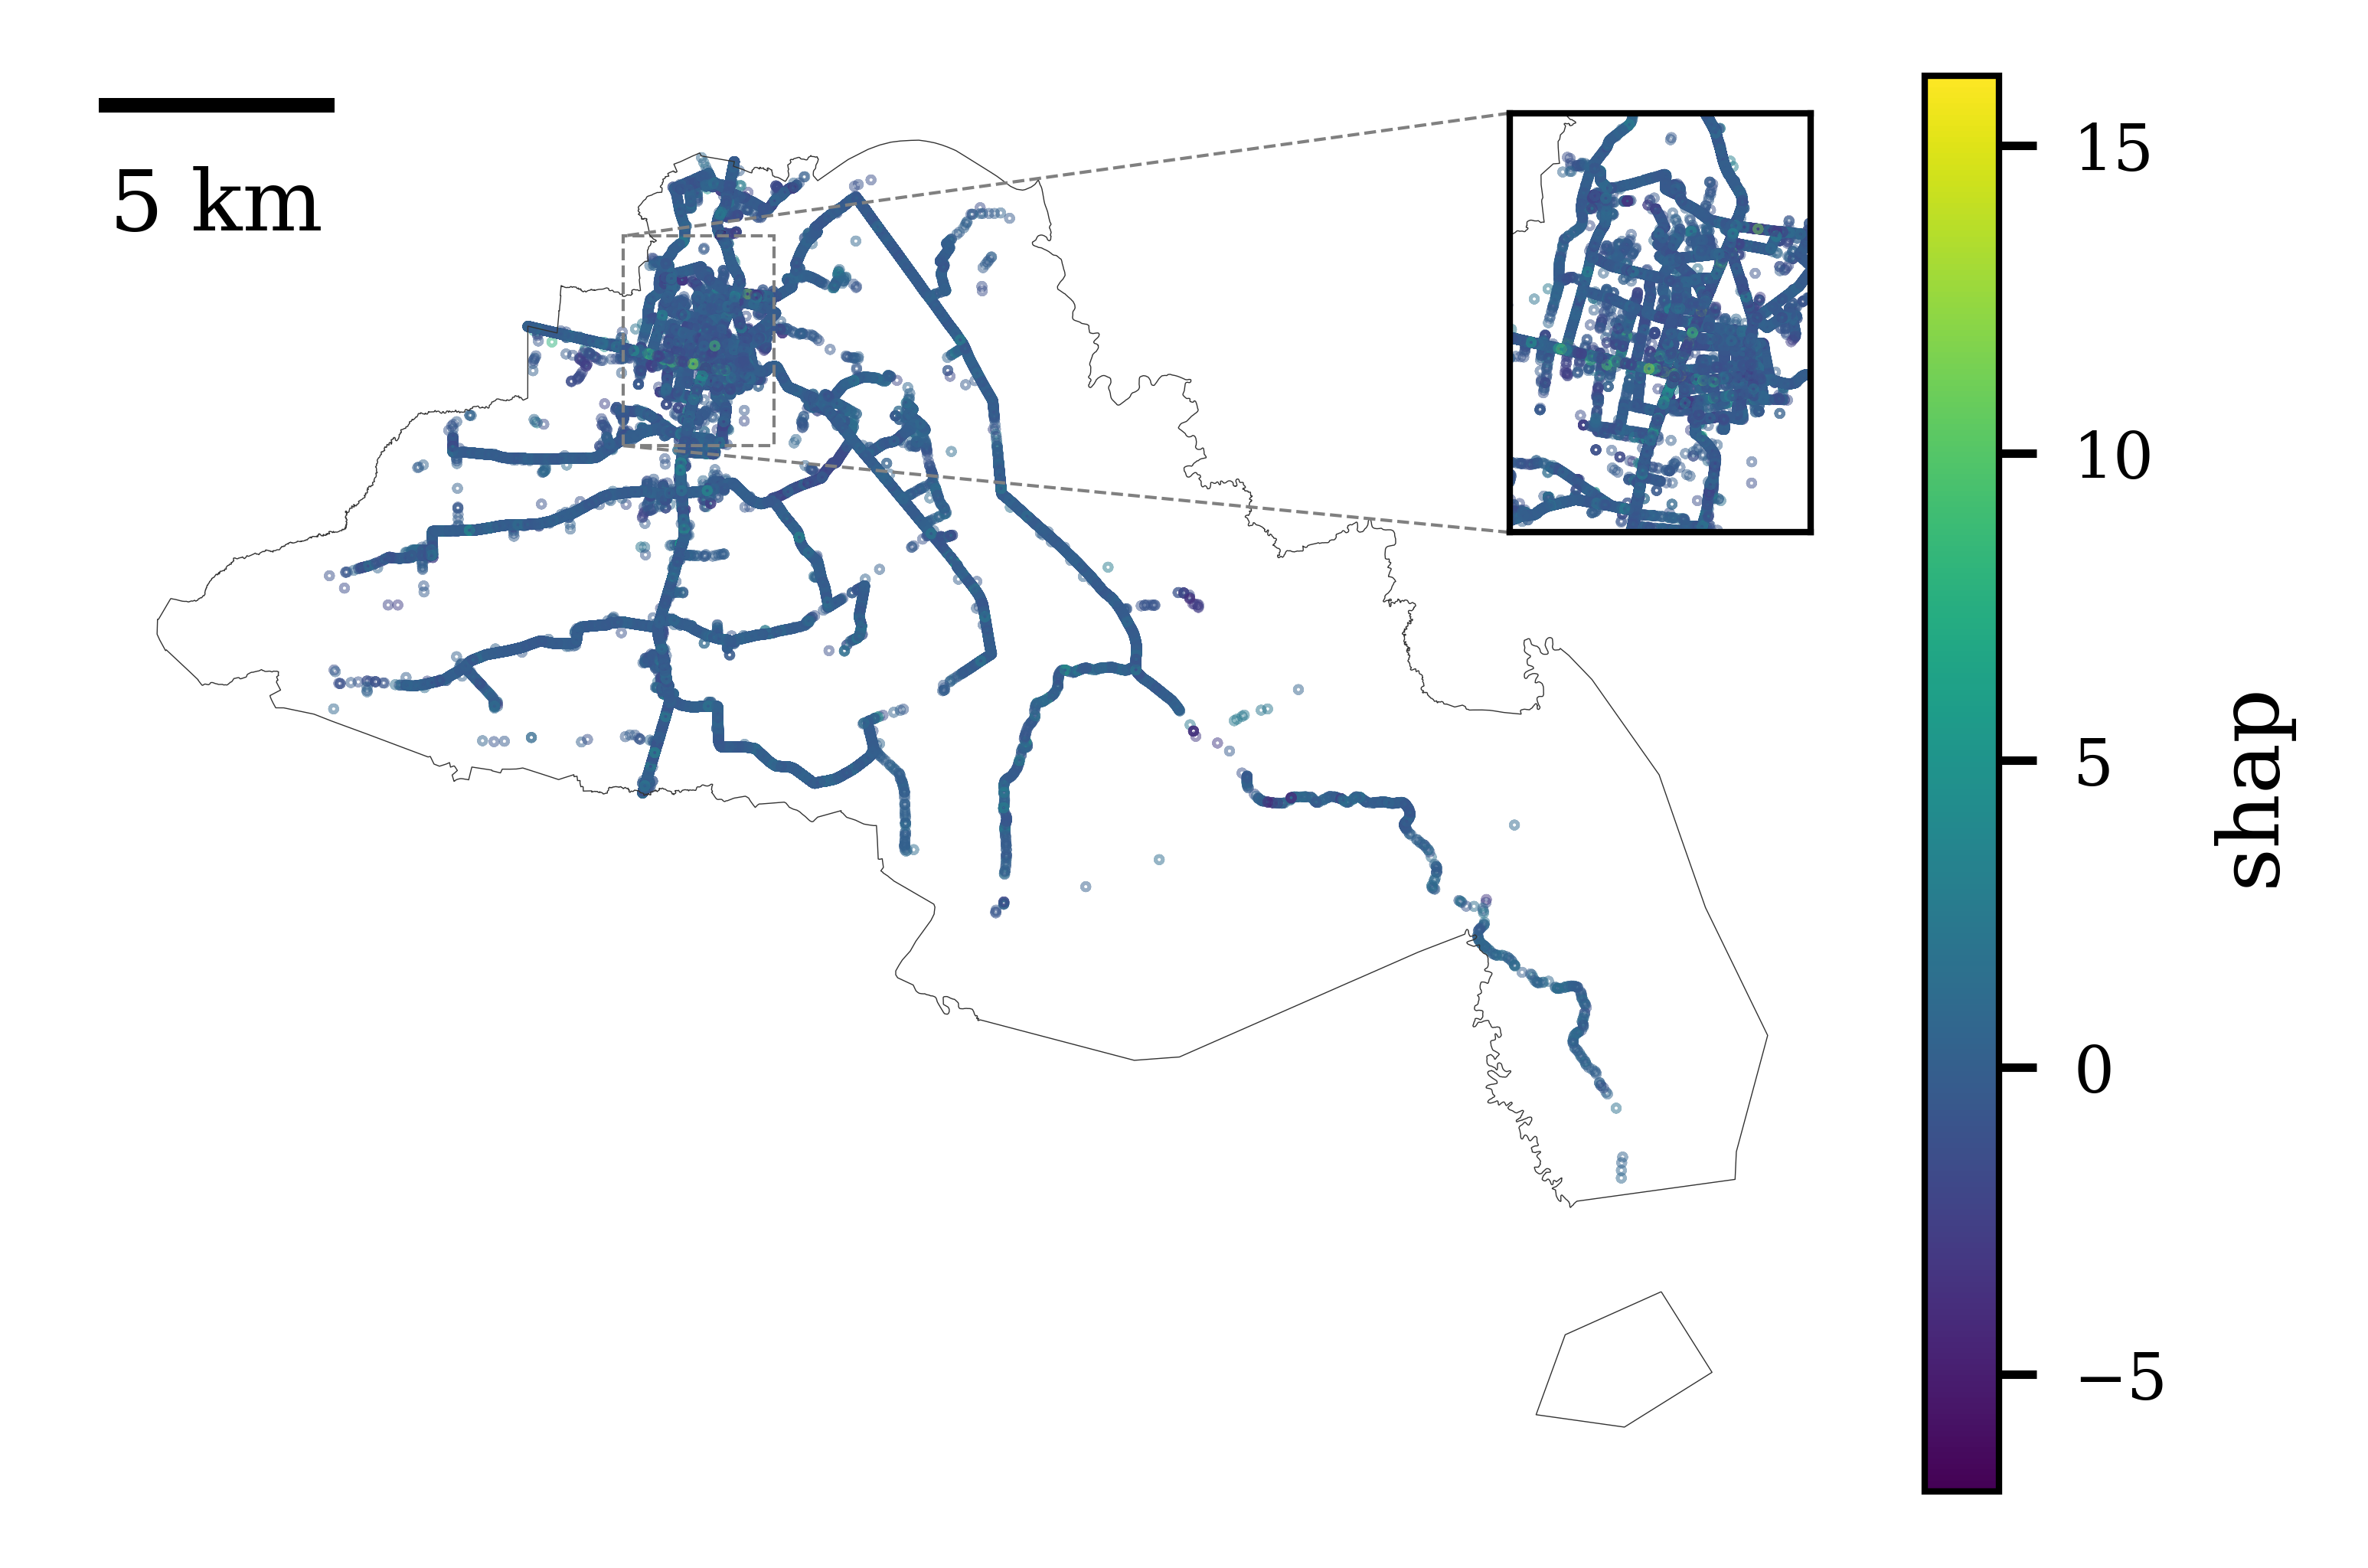

In [10]:
ms = 0.001
crs_ph = 3123
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib_scalebar.scalebar import ScaleBar
from shapely.geometry.point import Point
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

fig, ax = plt.subplots(1)
plt_kws = {'s': ms,
           'marker': '*',
           'alpha': 0.5}

def value_map_plot(data, ax, column=None, label=None, plt_kws=None):
    x_, y_ = data.geometry[0].coords[0]
    points = gpd.GeoSeries([Point(x_, y_), Point(x_+1, y_)], crs=4326)  # Geographic WGS 84 - degrees
    points = points.to_crs(crs_ph) # Projected WGS 84 - meters
    distance_meters = points[0].distance(points[1])

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="4%", pad="2%")


    data.plot(ax=ax, column=column, legend=True, cax=cax, **plt_kws)
    ax.axis('off')

    axins = zoomed_inset_axes(ax, 2, loc=1) # zoom = 6
    data.plot(ax=axins, column=column, **plt_kws)

    # sub region of the original image
    x1, x2, y1, y2 = 121.75, 121.78, 16.92, 16.96
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)

    axins.set_xticks([],visible=False)
    axins.set_yticks([],visible=False)

    mark_inset(ax, axins, loc1=2, loc2=3, fc="none", ec="0.5", lw=0.3, ls='--')
    ax.add_artist(ScaleBar(distance_meters, location='upper left'))
    if label is None and column:
        label = column
    cax.set_ylabel(column)
    return ax, axins
    
test_data['shap'] = shap_values[:,2] # use column name instead
ax, axins = value_map_plot(test_data, ax, column='shap', label='SHAP', plt_kws=plt_kws)
boundaries.geometry.boundary.plot(ax=ax, color='0.2', lw=0.1)
boundaries.geometry.boundary.plot(ax=axins, color='0.2', lw=0.1)

<AxesHostAxes:>

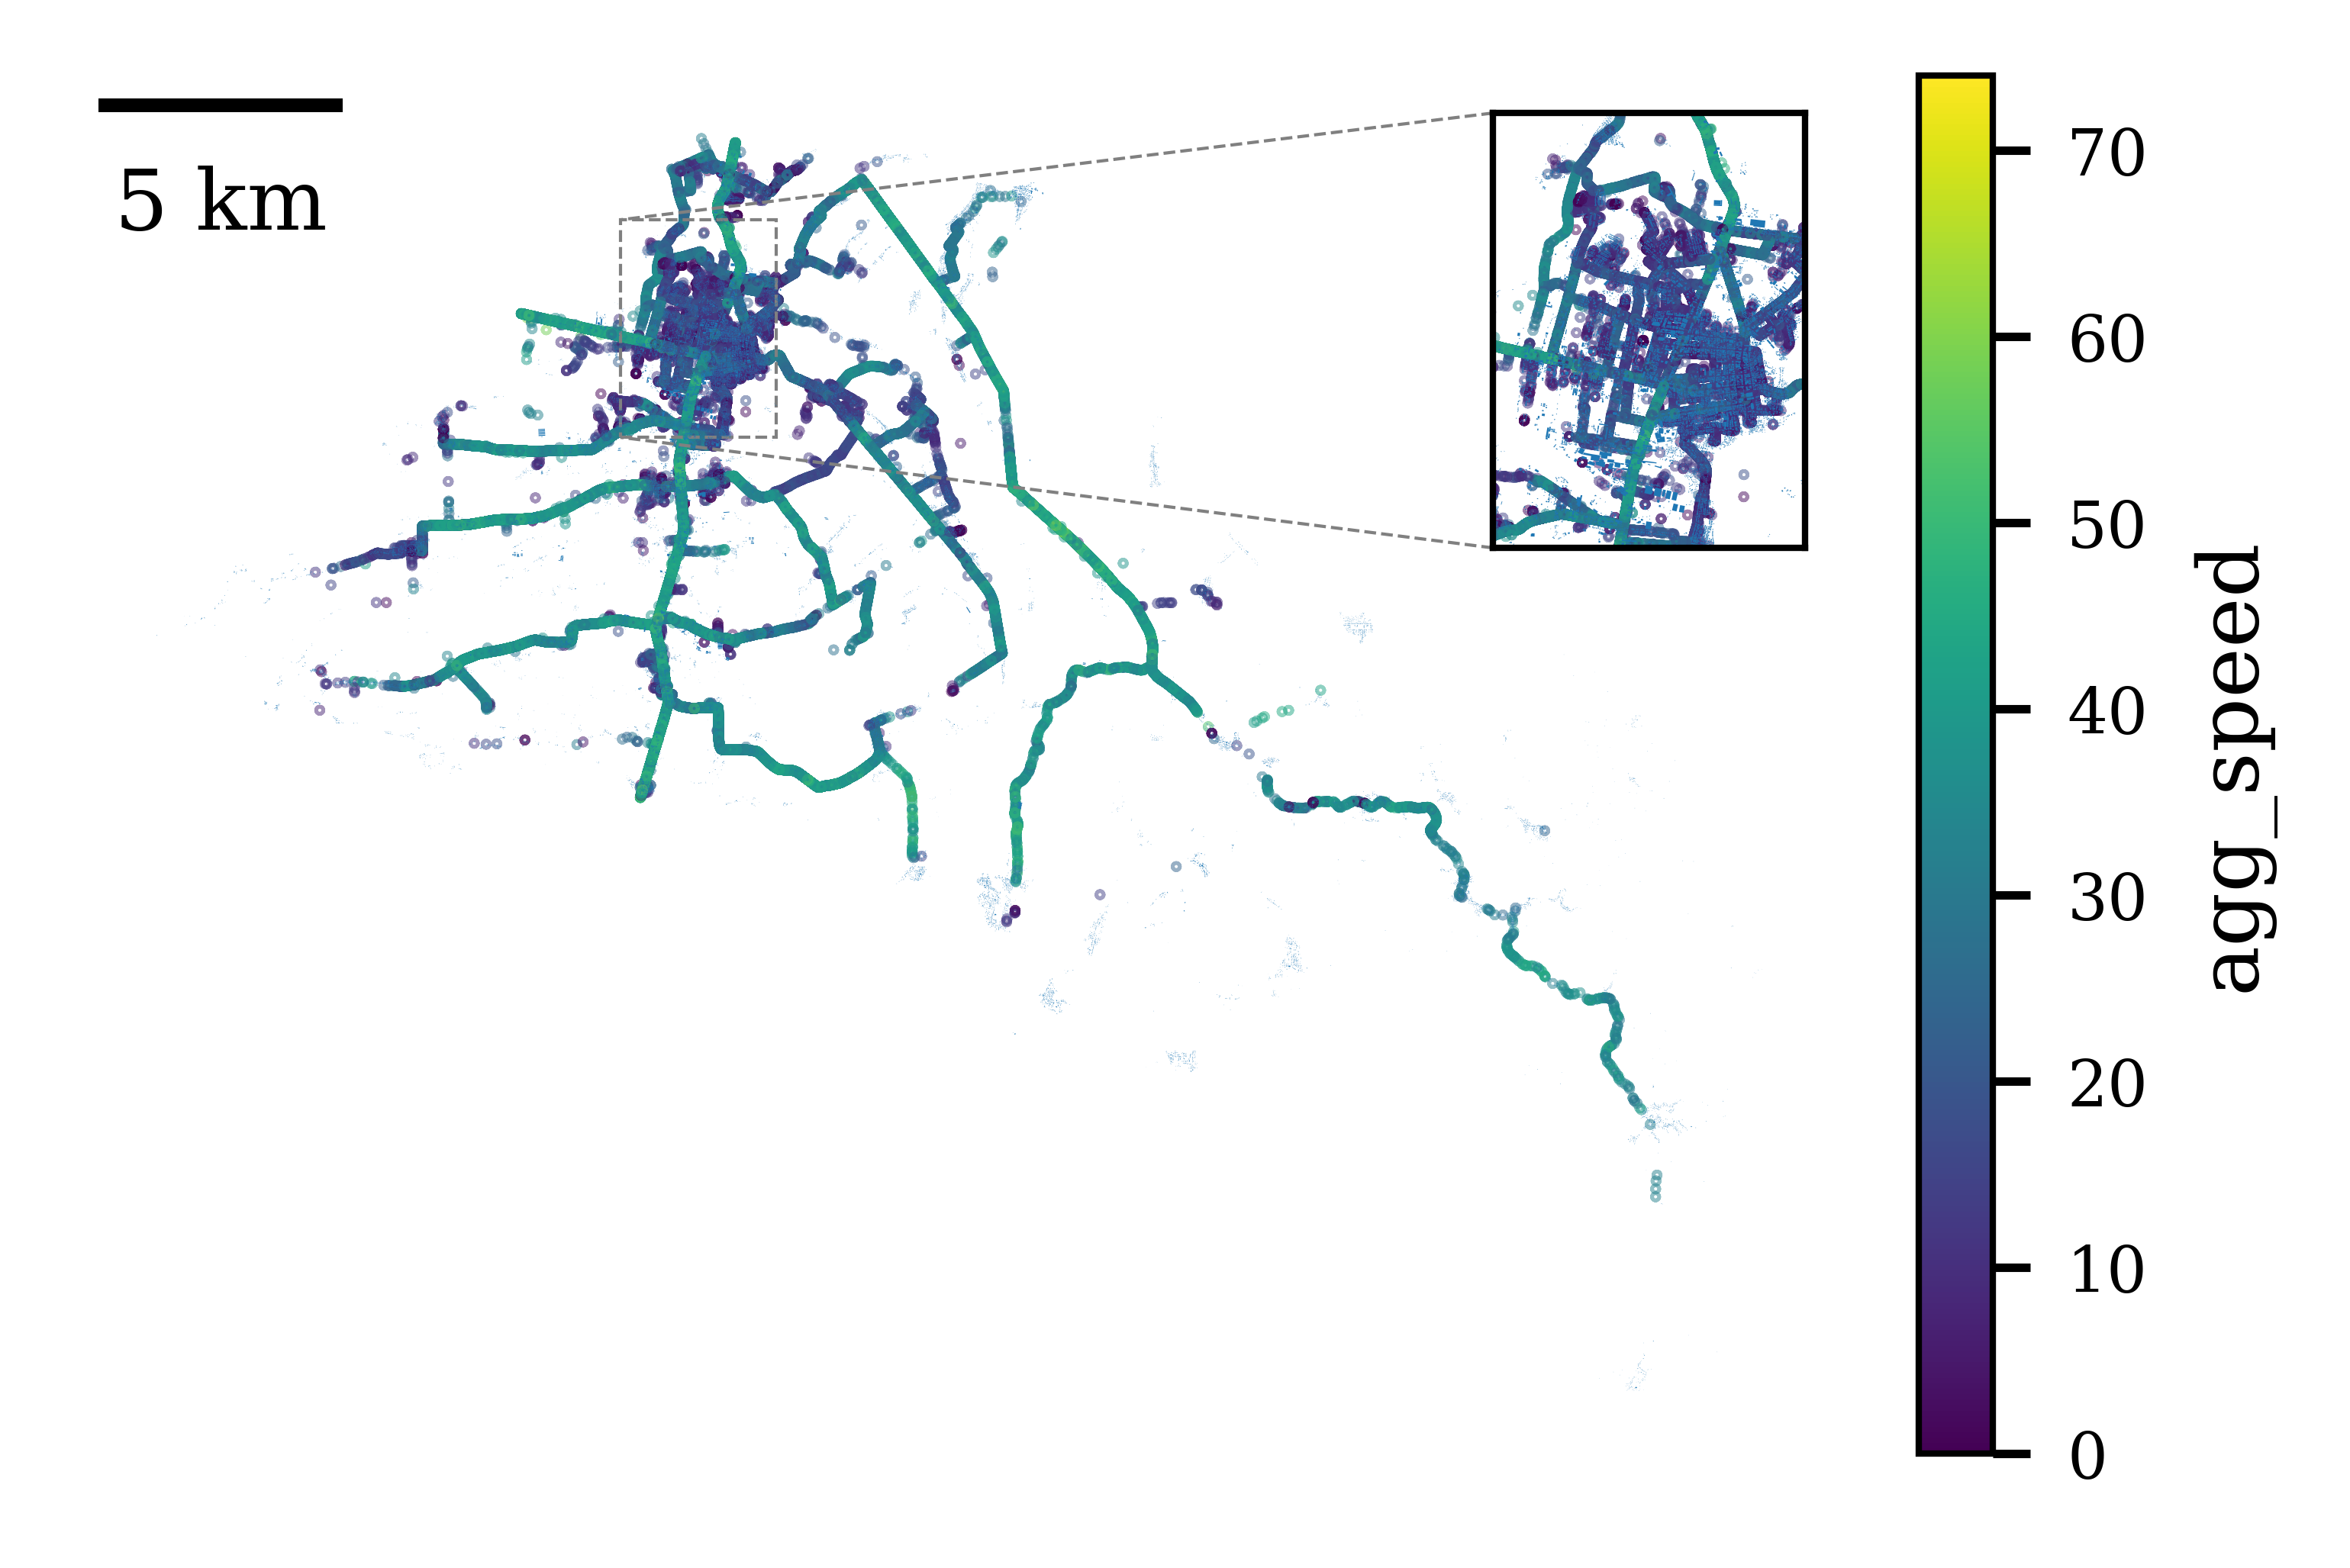

In [12]:
fig, ax = plt.subplots(1)
ax, axins = value_map_plot(test_data, ax, column='agg_speed', label='vehicle speed (km/hr)', plt_kws=plt_kws)
footprints.plot(ax=ax)
footprints.plot(ax=axins)

In [ ]:
# footprints.plot(ax=ax)
# footprints.plot(ax=axins)

# fig

<AxesSubplot:>

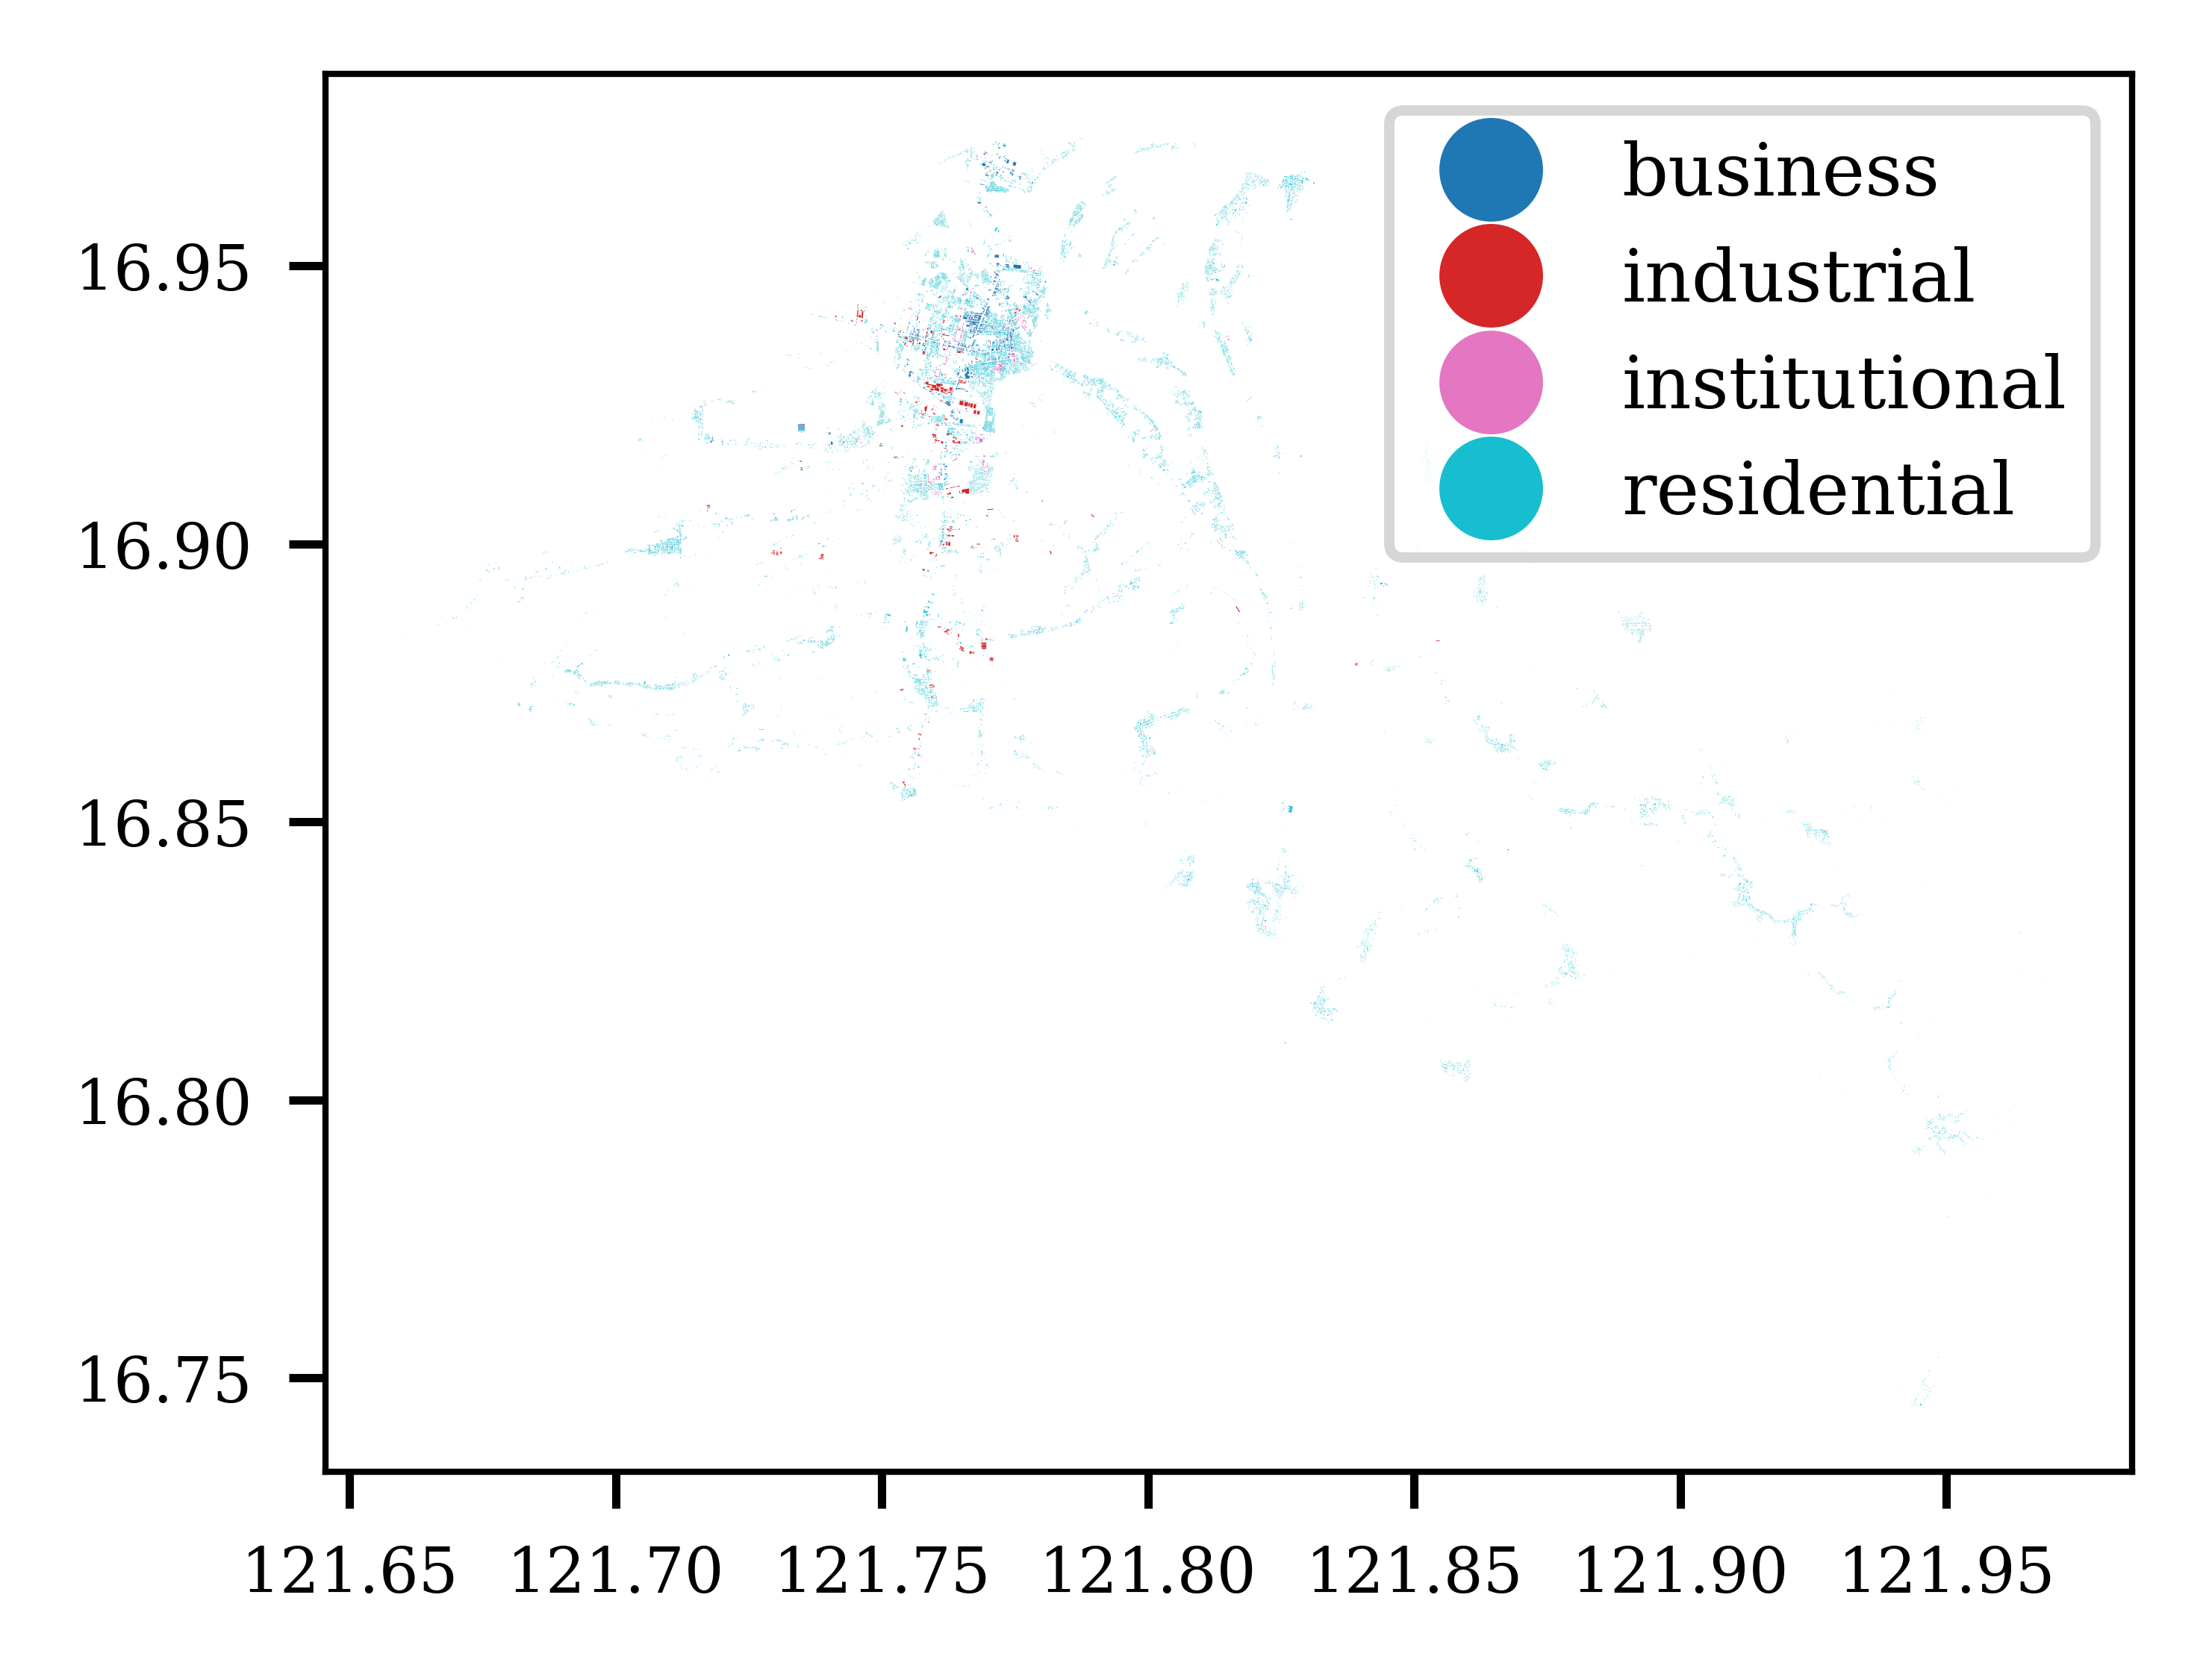

In [13]:
footprints.plot(column='Bldg_Class', legend=True)